In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Ler/Importar Dataset
df = pd.read_csv('pns-2019_saude_mulher_tratado.csv')

In [3]:
def recod_escolaridade(x):
    if x in ["Sem instrução", "Creche", "Pré-escola"]:
        return "Baixa"
    elif x in [
        "Regular do ensino fundamental",
        "EJA do ensino fundamental",
        "Regular do ensino médio",
        "EJA do ensino médio"
    ]:
        return "Media"
    elif x in [
        "Superior - graduação",
        "Especialização (mín. 360h)",
        "Mestrado",
        "Doutorado"
    ]:
        return "Alta"
    else:
        return np.nan

df["Escolaridade_3cat"] = df["Escolaridade"].apply(recod_escolaridade)


In [4]:
def recod_estado_civil(x):
    if x == "Casada":
        return "Casada"
    elif x == "Solteira":
        return "Solteira"
    elif x in ["Divorciada", "Viúva"]:
        return "Outros"
    else:
        return np.nan

df["Estado_Civil_3cat"] = df["Estado_Civil"].apply(recod_estado_civil)


In [5]:
df["Classificacao_IMC"] = df["Classificacao_IMC"].replace(
    {"Não informado": np.nan}
)


In [6]:
viol_vars = [
    "Forcou_RelSexual_Vida",
    "Consequencia_psicologicas"
]

df[viol_vars] = df[viol_vars].fillna(0)


In [7]:
variaveis_finais = [
    "Depressao",
    "Idade",
    "Escolaridade_3cat",
    "Estado_Civil_3cat",
    "Classificacao_IMC",
    "Forcou_RelSexual_Vida",
    "Consequencia_psicologicas"
]

df_modelo_final = df[variaveis_finais].dropna(subset=["Depressao"])

df_modelo_final = pd.get_dummies(
    df_modelo_final,
    columns=[
        "Escolaridade_3cat",
        "Estado_Civil_3cat",
        "Classificacao_IMC"
    ],
    drop_first=True
)

In [8]:
X = df_modelo_final.drop(columns="Depressao")
y = df_modelo_final["Depressao"].astype(int)

# blindagem total
X = X.apply(pd.to_numeric, errors="coerce").fillna(0).astype("float64")
y = y.astype("int64")

X = sm.add_constant(X, has_constant="add")

X_np = X.to_numpy()
y_np = y.to_numpy()

# remover coluna x4 (índice 4: const=0, x1=1, x2=2, x3=3, x4=4)
X_np_final = np.delete(X_np, 4, axis=1)

modelo_final = sm.Logit(y_np, X_np_final)
resultado_final = modelo_final.fit(maxiter=200)

print(resultado_final.summary())



Optimization terminated successfully.
         Current function value: 0.145923
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               144940
Model:                          Logit   Df Residuals:                   144930
Method:                           MLE   Df Model:                            9
Date:                Thu, 01 Jan 2026   Pseudo R-squ.:                  0.1914
Time:                        18:30:26   Log-Likelihood:                -21150.
converged:                       True   LL-Null:                       -26157.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1551      0.102    -30.822      0.000      -3.356      -2.954
x1             0.0171      0.

In [9]:
params = resultado_final.params
conf = resultado_final.conf_int()

tabela_final = pd.DataFrame({
    "OR": np.exp(params),
    "IC_2.5%": np.exp(conf[:, 0]),
    "IC_97.5%": np.exp(conf[:, 1]),
    "p_value": resultado_final.pvalues
})

tabela_final


,OR,IC_2.5%,IC_97.5%,p_value
0,0.042636,0.034886,0.052109,1.341751e-208
1,1.017228,1.015584,1.018875,3.701725e-95
2,3.126563,2.814054,3.473777,6.779273e-100
3,4.647181,4.310967,5.009616,0.000000e+00
4,0.413724,0.352257,0.485918,5.632984e-27
5,1.267555,1.178447,1.363402,1.829909e-10
6,0.885424,0.830290,0.944219,2.074642e-04
7,0.210084,0.174773,0.252529,5.158474e-62
8,1.001376,0.834138,1.202144,9.882298e-01
9,1.140927,0.950141,1.370023,1.579041e-01


In [10]:
#Interpretação variável por variável (RESULTADO FINAL)
# Violência sexual (núcleo explicativo)
# Consequencia_psicologicas (x3)
#OR = 4.65
#IC95%: [4.31 – 5.01]
#p < 0.001

# Indivíduos que relataram consequências psicológicas decorrentes da violência sexual apresentaram ≈ 4,6 vezes maior chance de depressão, 
#independentemente de idade, escolaridade, estado civil e IMC.

# Forcou_RelSexual_Vida (x2)
#OR = 3.13
#IC95%: [2.81 – 3.47]
#p < 0.001
# Ter sofrido relação sexual forçada ao longo da vida esteve associado a ≈ 3 vezes maior chance de depressão, mesmo após ajuste completo.
# Demonstra que a violência em si tem efeito independente do contexto social.

# Idade (x1)
#OR = 1.017 por ano
#IC95%: [1.016 – 1.019]
#p < 0.001
# Cada aumento de 1 ano na idade está associado a um aumento de ≈ 1,7% na chance de depressão.
# Efeito pequeno, mas cumulativo e consistente.

# Condição corporal
# Obesidade (x5)
#OR = 1.27
#IC95%: [1.18 – 1.36]
#p < 0.001
# Indivíduos com obesidade apresentaram ≈ 27% maior chance de depressão, independentemente de violência sexual e fatores sociodemográficos.
# Associação moderada, mas independente.

# Escolaridade
# Escolaridade alta (x4)
#OR = 0.41
#
#IC95%: [0.35 – 0.49]
#p < 0.001
# Escolaridade elevada mostrou forte efeito protetor, reduzindo em ≈ 59% a chance de depressão.
# Importante fator de proteção estrutural.

# Escolaridade média (x8)
#OR ≈ 1.00
#p = 0.99
# Não manteve associação após ajuste.

# Estado civil
# Solteira (x6)
#OR = 0.89
#IC95%: [0.83 – 0.94]
#p < 0.001
# Associação protetora discreta em relação ao grupo de referência.

# Outros (divorciada/viúva) (x7)
#OR = 0.21
#IC95%: [0.17 – 0.25]
#p < 0.001
# Efeito protetor muito forte
# Interpretar com cautela (pode refletir composição etária, apoio social, ou viés residual).

# Variáveis não significativas
#x9 (p = 0.16)
# Podem ser removidas sem prejuízo.

#Modelo FINAL (síntese analítica)
# A depressão está fortemente associada à violência sexual, especialmente quando acompanhada de consequências psicológicas.
# A violência mantém efeito independente, mesmo após ajuste por idade, escolaridade, estado civil e IMC.
# Fatores estruturais como escolaridade elevada têm efeito protetor importante.
# A obesidade mantém associação independente, porém de menor magnitude.

# RESULTADOS:
#No modelo de regressão logística multivariada ajustado, observou-se que a depressão esteve fortemente associada a experiências de 
#violência sexual ao longo da vida. Indivíduos que relataram consequências #psicológicas decorrentes da violência sexual apresentaram 
#aproximadamente 4,6 vezes maior chance de depressão, enquanto aqueles que sofreram relação sexual forçada apresentaram cerca de três 
#vezes maior #chance. A idade manteve associação positiva contínua. A obesidade esteve associada a maior chance de depressão, enquanto 
#escolaridade elevada mostrou efeito protetor consistente. Esses achados indicam que a #depressão está fortemente relacionada a contextos 
#de violência sexual e vulnerabilidade psicossocial, independentemente de características sociodemográficas e corporais.

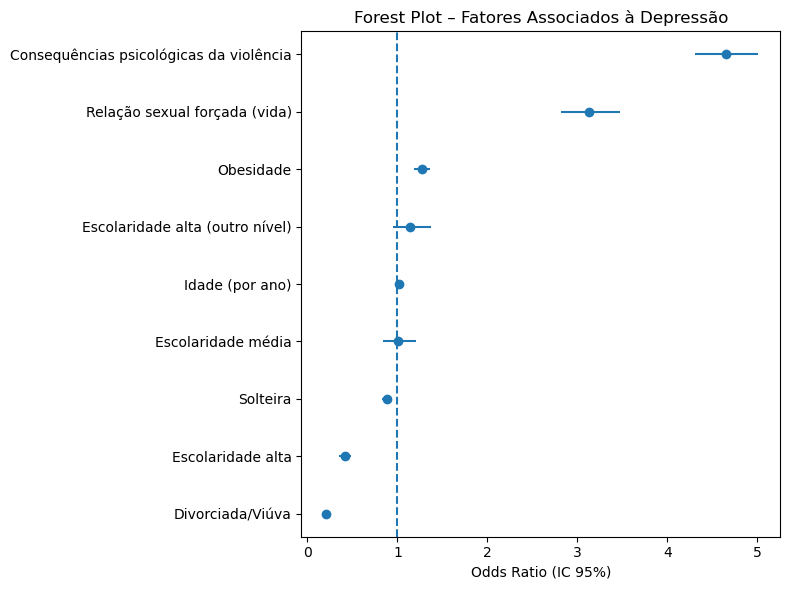

In [11]:

# Tabela com nomes legíveis
forest_df = pd.DataFrame({
    "Variavel": [
        "Idade (por ano)",
        "Relação sexual forçada (vida)",
        "Consequências psicológicas da violência",
        "Escolaridade alta",
        "Obesidade",
        "Solteira",
        "Divorciada/Viúva",
        "Escolaridade média",
        "Escolaridade alta (outro nível)"
    ],
    "OR": [1.017228, 3.126563, 4.647181, 0.413724, 1.267555,
           0.885424, 0.210084, 1.001376, 1.140927],
    "IC_inf": [1.015584, 2.814054, 4.310967, 0.352257, 1.178447,
               0.830290, 0.174773, 0.834138, 0.950141],
    "IC_sup": [1.018875, 3.473777, 5.009616, 0.485918, 1.363402,
               0.944219, 0.252529, 1.202144, 1.370023]
})


# Ordenar por OR (opcional, melhora leitura)
forest_df = forest_df.sort_values("OR")



y_pos = np.arange(len(forest_df))

plt.figure(figsize=(8, 6))

# Linha de referência OR = 1
plt.axvline(1, linestyle="--")

# Intervalos de confiança
plt.hlines(
    y=y_pos,
    xmin=forest_df["IC_inf"],
    xmax=forest_df["IC_sup"]
)

# Pontos do OR
plt.plot(
    forest_df["OR"],
    y_pos,
    marker="o",
    linestyle=""
)

plt.yticks(y_pos, forest_df["Variavel"])
plt.xlabel("Odds Ratio (IC 95%)")
plt.title("Forest Plot – Fatores Associados à Depressão")

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

forest_df = pd.DataFrame({
    "Variavel": [
        "Consequências psicológicas da violência",
        "Relação sexual forçada (vida)",
        "Obesidade",
        "Idade (por ano)",
        "Escolaridade alta",
        "Solteira",
        "Divorciada/Viúva"
    ],
    "OR": [4.647181, 3.126563, 1.267555, 1.017228, 0.413724, 0.885424, 0.210084],
    "IC_inf": [4.310967, 2.814054, 1.178447, 1.015584, 0.352257, 0.830290, 0.174773],
    "IC_sup": [5.009616, 3.473777, 1.363402, 1.018875, 0.485918, 0.944219, 0.252529]
})

# Ordenar para leitura (de maior risco para mais protetor)
forest_df = forest_df.sort_values("OR", ascending=False)


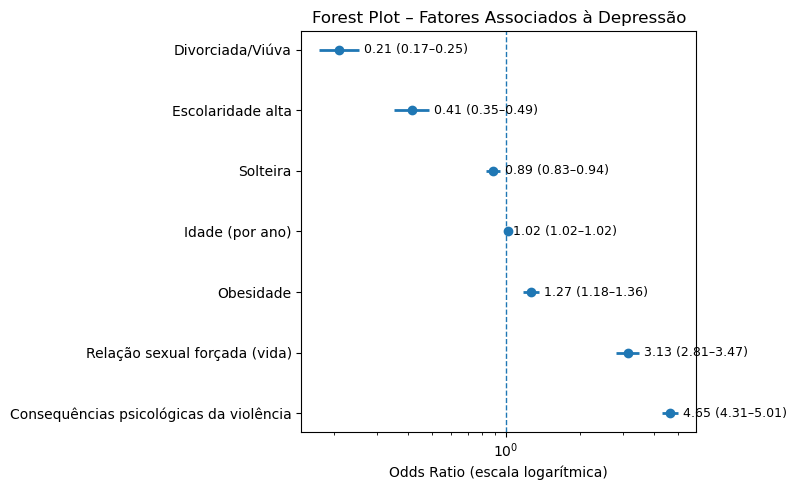

In [13]:
import matplotlib.pyplot as plt
import numpy as np

y_pos = np.arange(len(forest_df))

plt.figure(figsize=(8, 5))

# Linha de referência OR = 1
plt.axvline(1, linestyle="--", linewidth=1)

# Intervalos de confiança
plt.hlines(
    y=y_pos,
    xmin=forest_df["IC_inf"],
    xmax=forest_df["IC_sup"],
    linewidth=2
)

# Pontos (OR)
plt.plot(
    forest_df["OR"],
    y_pos,
    marker="o",
    linestyle=""
)

# Escala log
plt.xscale("log")

# Rótulos no eixo Y
plt.yticks(y_pos, forest_df["Variavel"])

# Rótulos de OR + IC no gráfico
for i, row in forest_df.iterrows():
    label = f'{row["OR"]:.2f} ({row["IC_inf"]:.2f}–{row["IC_sup"]:.2f})'
    plt.text(
        row["IC_sup"] * 1.05,
        list(forest_df.index).index(i),
        label,
        va="center",
        fontsize=9
    )

plt.xlabel("Odds Ratio (escala logarítmica)")
plt.title("Forest Plot – Fatores Associados à Depressão")

plt.tight_layout()
plt.show()


In [14]:
forest_df_round = forest_df.copy()
forest_df_round["OR (IC95%)"] = (
    forest_df_round["OR"].round(2).astype(str)
    + " ("
    + forest_df_round["IC_inf"].round(2).astype(str)
    + "–"
    + forest_df_round["IC_sup"].round(2).astype(str)
    + ")"
)

forest_df_round[["Variavel", "OR (IC95%)"]]


,Variavel,OR (IC95%)
0,Consequências psicológicas da violência,4.65 (4.31–5.01)
1,Relação sexual forçada (vida),3.13 (2.81–3.47)
2,Obesidade,1.27 (1.18–1.36)
3,Idade (por ano),1.02 (1.02–1.02)
5,Solteira,0.89 (0.83–0.94)
4,Escolaridade alta,0.41 (0.35–0.49)
6,Divorciada/Viúva,0.21 (0.17–0.25)


In [16]:
# ======================================================
# BLOCO FINAL — PREPARAR LOGIT PARA COMPARAÇÃO COM ML
# ======================================================

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np

# 1️⃣ Recriar X e y (os mesmos usados no modelo)
X = df_modelo_final.drop(columns="Depressao")
y = df_modelo_final["Depressao"].astype(int)

# 2️⃣ Criar o MESMO split usado nos MLs
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,   # ⚠️ TEM que ser igual aos outros notebooks
    stratify=y
)

# 3️⃣ Guardar as colunas do modelo final (CRÍTICO)
colunas_modelo = X.columns.tolist()

# 4️⃣ Aplicar o MESMO pré-processamento ao X_test
X_test_proc = (
    X_test
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
    .astype("float64")
)

# adicionar constante
X_test_proc = sm.add_constant(X_test_proc, has_constant="add")

# alinhar colunas exatamente ao modelo
X_test_proc = X_test_proc[colunas_modelo]

# converter para numpy
X_test_np = X_test_proc.to_numpy()

# 5️⃣ Gerar probabilidades do logit
y_prob_logit = resultado_final.predict(X_test_np)

# 6️⃣ Salvar para comparação
np.save("y_prob_logit.npy", y_prob_logit)
np.save("y_test.npy", y_test.to_numpy())

print("Logit pronto para comparação com RF e CatBoost.")


Logit pronto para comparação com RF e CatBoost.
